In [1]:
!pip install xlrd
!pip install nltk
!pip install gensim
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
2021-07-23 14:11:49.810007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-07-23 14:11:49.811723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Import libraries

In [1]:
import numpy as np
import tqdm
import os
import pandas as pd
import nltk
import re
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import spacy
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import pickle

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

/Users/manishagarwal/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Download stopwords

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Import data

In [4]:
# read xls file
df = pd.read_excel('Final.xlsx', sheet_name='Data',engine='openpyxl')
# if above import doesn't work, use the one below
#df = pd.read_excel('Final.xlsx', sheet_name='Data')
df = df.astype(str)
print(df.shape)
df.head()

(38483, 6)


,title,link,excerpt,timestamp,body,company
0,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSKBN2BO42D,...By Carl O'Donnell (Reuters) - Abbott Labora...,"APRIL 01, 2021 11:55AM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES
1,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSL1N2LS2TL,...By Carl O'Donnell March 31 (Reuters) - Abbo...,"MARCH 31, 2021 11:18PM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES
2,Blank-check firm Union Acquisition Corp II to ...,https://www.reuters.com/article/idUSL4N2LS4GA,"..., which was bought by Abbott Laboratories i...","MARCH 31, 2021 07:45AM EDT",['March 31 (Reuters) - US blank-check company ...,ABBOTT LABORATORIES
3,Roche test boss says COVID rapid test effectiv...,https://www.reuters.com/article/idUSKBN2BF1YT,... that compete with diagnostics from rivals ...,"MARCH 23, 2021 11:24AM EDT",['ZURICH (Reuters) - Rapid COVID-19 tests that...,ABBOTT LABORATORIES
4,UPDATE 1-Roche test boss says COVID rapid test...,https://www.reuters.com/article/idUSL8N2LL5HU,"... rivals including Abbott Laboratories. ""If ...","MARCH 23, 2021 11:00AM EDT","['(Adds details, comment from diagnostics head...",ABBOTT LABORATORIES


### Preprocessing data

In [5]:
# remove duplicates and n/a
df2 = df.dropna(how='all',subset=['body'])
df2 = df2.drop_duplicates(subset=['link', 'body'], keep='first')
df2.reset_index(drop=True, inplace=True)
df2

,title,link,excerpt,timestamp,body,company
0,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSKBN2BO42D,...By Carl O'Donnell (Reuters) - Abbott Labora...,"APRIL 01, 2021 11:55AM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES
1,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSL1N2LS2TL,...By Carl O'Donnell March 31 (Reuters) - Abbo...,"MARCH 31, 2021 11:18PM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES
2,Blank-check firm Union Acquisition Corp II to ...,https://www.reuters.com/article/idUSL4N2LS4GA,"..., which was bought by Abbott Laboratories i...","MARCH 31, 2021 07:45AM EDT",['March 31 (Reuters) - US blank-check company ...,ABBOTT LABORATORIES
3,Roche test boss says COVID rapid test effectiv...,https://www.reuters.com/article/idUSKBN2BF1YT,... that compete with diagnostics from rivals ...,"MARCH 23, 2021 11:24AM EDT",['ZURICH (Reuters) - Rapid COVID-19 tests that...,ABBOTT LABORATORIES
4,UPDATE 1-Roche test boss says COVID rapid test...,https://www.reuters.com/article/idUSL8N2LL5HU,"... rivals including Abbott Laboratories. ""If ...","MARCH 23, 2021 11:00AM EDT","['(Adds details, comment from diagnostics head...",ABBOTT LABORATORIES
...,...,...,...,...,...,...
27849,China shares reverse gains after regulator war...,https://www.reuters.com/article/idUSAZN00XV6D,...% after a 1.66% rise on Monday. Wuliangye Y...,"MARCH 02, 2021 02:31AM EST",['* Shares erase early gains after regulator c...,WULIANGYE YIBIN
27850,China shares fall as consumer firms drag; Hong...,https://www.reuters.com/article/idUSL2N2L007X,.... Kweichow Moutai Co Ltd slumped 3.61% afte...,"MARCH 01, 2021 11:56PM EST",['* China annual parliament session to start o...,WULIANGYE YIBIN
27851,China shares slump as COVID-19 cases surge,https://www.reuters.com/article/idUSAZN00SAXU,...%. Distiller Wuliangye Yibin Co Ltd tumbled...,"JANUARY 14, 2021 02:44AM EST","['SHANGHAI, Jan 14 (Reuters) - China’s blue-ch...",WULIANGYE YIBIN
27852,Consumer firms drag China shares lower; Alibab...,https://www.reuters.com/article/idUSL1N2JP0BP,"... by distiller Wuliangye Yibin Co Ltd, which...","JANUARY 14, 2021 12:14AM EST","['* SSEC -029%, CSI300 -108%, HSI up 049%', '*...",WULIANGYE YIBIN


In [6]:
# Remove punctuation
#df2['body_processed'] = df2['body'].map(lambda x: re.sub('[,\.!?]', '', x))
df2['body_processed'] = df2['body'].map(lambda x: re.sub('^[a-z]+$', '', x))

# Convert the titles to lowercase
df2['body_processed'] = df2['body_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df2['body_processed'].head()

0    ['(reuters) - abbott laboratories said on wedn...
1    ['(reuters) - abbott laboratories said on wedn...
2    ['march 31 (reuters) - us blank-check company ...
3    ['zurich (reuters) - rapid covid-19 tests that...
4    ['(adds details, comment from diagnostics head...
Name: body_processed, dtype: object

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df2.body_processed.values.tolist()
data_words = list(sent_to_words(data))

### Bigrams/Trigrams

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# stopwords
stop_words = stopwords.words('english')
stop_words.extend(['company', 'market', 'week', 'month', 'year', 'country', 'include', 'business', 'll', 've', '0', '1', '10', '2', '2012', '2013', '2014', '3', '4', '5', '6', '7', '8', '9', 'a', 'as', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ah', 'aint', 'ako', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'ang', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'apparently', 'appear', 'appreciate', 'appropriate', 'approximately', 'are', 'aren', 'arent', 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'august', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'biol', 'both', 'bottom', 'brief', 'briefly', 'but', 'by', 'c', 'cmon', 'cs', 'ca', 'call', 'came', 'can', 'cant', 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'con', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'contains', 'corresponding', 'could', 'couldnt', 'couldnt', 'course', 'currently', 'd', 'date', 'day', 'de', 'december', 'definitely', 'describe', 'described', 'despite', 'detail', 'did', 'didnt', 'different', 'do', 'does', 'doesnt', 'doing', 'don', 'dont', 'done', 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 'eg', 'eight', 'eighty', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'end', 'ending', 'enough', 'entirely', 'especially', 'et', 'et-al', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'f', 'far', 'february', 'few', 'ff', 'fifteen', 'fifth', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'fix', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'forty', 'found', 'four', 'fri', 'friday', 'from', 'front', 'full', 'further', 'furthermore', 'g', 'gave', 'get', 'gets', 'getting', 'give', 'given', 'gives', 'giving', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'government', 'greetings', 'h', 'had', 'hadnt', 'happens', 'hardly', 'has', 'hasnt', 'hasnt', 'have', 'havent', 'having', 'he', 'hed', 'hell', 'hes', 'hed', 'hello', 'help', 'hence', 'her', 'here', 'heres', 'hereafter', 'hereby', 'herein', 'heres', 'hereupon', 'hers', 'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'homepage', 'hopefully', 'how', 'hows', 'howbeit', 'however', 'hundred', 'i', 'id', 'ill', 'im', 'ive', 'id', 'ie', 'if', 'ignored', 'im', 'immediate', 'immediately', 'importance', 'important', 'in', 'inasmuch', 'inc', 'indeed', 'index', 'indicate', 'indicated', 'indicates', 'information', 'inner', 'inquirer', 'insofar', 'instead', 'into', 'invention', 'inward', 'is', 'isnt', 'it', 'itd', 'itll', 'its', 'itd', 'its', 'itself', 'j', 'january', 'july', 'june', 'just', 'k', 'keep', 'keeps', 'kept', 'kg', 'km', 'know', 'known', 'knows', 'ko', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'lets', 'lets', 'like', 'liked', 'likely', 'line', 'little', 'look', 'looking', 'looks', 'ltd', 'm', 'made', 'mainly', 'make', 'makes', 'manila', 'many', 'march', 'may', 'maybe', 'me', 'mean', 'means', 'meantime', 'meanwhile', 'merely', 'mg', 'might', 'mill', 'million', 'mine', 'miss', 'ml', 'mon', 'monday', 'more', 'moreover', 'most', 'mostly', 'move', 'mr', 'mrs', 'much', 'mug', 'must', 'mustnt', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 'near', 'nearly', 'necessarily', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'newsinfo', 'next', 'ng', 'nine', 'ninety', 'no', 'nobody', 'non', 'none', 'nonetheless', 'noone', 'nor', 'normally', 'nos', 'not', 'noted', 'nothing', 'novel', 'november', 'now', 'nowhere', 'o', 'obtain', 'obtained', 'obviously', 'october', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 'past', 'people', 'per', 'percent', 'perhaps', 'philippine', 'photo', 'placed', 'please', 'plus', 'pm', 'police', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 'predominantly', 'present', 'presumably', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 'put', 'q', 'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rappler', 'rapplercom', 'rather', 'rd', 're', 'readily', 'really', 'reasonably', 'recent', 'recently', 'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 'research', 'respectively', 'resulted', 'resulting', 'results', 'reuters', 'right', 'run', 's', 'sa', 'said', 'same', 'sat', 'saturday', 'saw', 'say', 'saying', 'says', 'sec', 'second', 'secondly', 'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'september', 'serious', 'seriously', 'seven', 'several', 'shall', 'shant', 'she', 'shed', 'shell', 'shes', 'shed', 'shes', 'should', 'shouldnt', 'show', 'showed', 'shown', 'showns', 'shows', 'side', 'significant', 'significantly', 'similar', 'similarly', 'since', 'sincere', 'singapore', 'six', 'sixty', 'slightly', 'so', 'some', 'somebody', 'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'sports', 'still', 'stop', 'stories', 'story', 'strongly', 'sub', 'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sunday', 'sup', 'sure', 't', 'ts', 'take', 'taken', 'taking', 'tell', 'ten', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', 'thatll', 'thats', 'thatve', 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'therell', 'theres', 'thereve', 'thereafter', 'thereby', 'thered', 'therefore', 'therein', 'thereof', 'therere', 'theres', 'thereto', 'thereupon', 'these', 'they', 'theyd', 'theyll', 'theyre', 'theyve', 'theyd', 'theyre', 'thickv', 'thin', 'think', 'third', 'this', 'thorough', 'thoroughly', 'those', 'thou', 'though', 'thoughh', 'thousand', 'three', 'throug', 'through', 'throughout', 'thru', 'thu', 'thursday', 'thus', 'til', 'time', 'tip', 'to', 'together', 'told', 'too', 'took', 'top', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'tue', 'tuesday', 'tweet', 'twelve', 'twenty', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 'used', 'useful', 'usefully', 'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', 'very', 'via', 'viz', 'vol', 'vols', 'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'wasnt', 'way', 'we', 'wed', 'well', 'were', 'weve', 'wed', 'wednesday', 'welcome', 'well', 'went', 'were', 'werent', 'werent', 'what', 'whatll', 'whats', 'whatever', 'whats', 'when', 'whens', 'whence', 'whenever', 'where', 'wheres', 'whereafter', 'whereas', 'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 'wholl', 'whos', 'whod', 'whoever', 'whole', 'whom', 'whomever', 'whos', 'whose', 'why', 'whys', 'widely', 'will', 'willing', 'wish', 'with', 'within', 'without', 'wont', 'wonder', 'wont', 'words', 'world', 'would', 'wouldnt', 'wouldnt', 'www', 'x', 'y', 'yahoo', 'year', 'years', 'yes', 'yet', 'you', 'youd', 'youll', 'youre', 'youve', 'youd', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'yung', 'z', 'zero'])


### Further preprocessing

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(nlp, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

## Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(nlp, data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Create Corpus

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0][0][:30])

(0, 1)


In [2]:
def save_obj(obj, name ):
    with open('model/' + name +'_tri.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('model/' + name + '_tri.pkl', 'rb') as f:
        return pickle.load(f)

In [17]:
save_obj(corpus, 'corpus')
save_obj(id2word, 'id2word')

### Test LDA model

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=20, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"game" + 0.010*"point" + 0.009*"win" + 0.009*"team" + 0.009*"play" + '
  '0.008*"lead" + 0.008*"woman" + 0.006*"player" + 0.006*"open" + '
  '0.005*"season"'),
 (1,
  '0.023*"gold" + 0.016*"airline" + 0.010*"ounce" + 0.009*"flight" + '
  '0.009*"miner" + 0.009*"travel" + 0.008*"plane" + 0.008*"production" + '
  '0.007*"jet" + 0.007*"max"'),
 (2,
  '0.027*"patient" + 0.024*"drug" + 0.021*"covid" + 0.018*"trial" + '
  '0.017*"test" + 0.016*"treatment" + 0.014*"study" + 0.011*"remdesivir" + '
  '0.009*"datum" + 0.008*"vaccine"'),
 (3,
  '0.020*"economy" + 0.016*"growth" + 0.015*"rise" + 0.013*"economic" + '
  '0.011*"recovery" + 0.011*"high" + 0.010*"expect" + 0.010*"pandemic" + '
  '0.010*"sector" + 0.010*"demand"'),
 (4,
  '0.012*"case" + 0.011*"state" + 0.011*"worker" + 0.010*"court" + '
  '0.010*"company" + 0.009*"law" + 0.008*"claim" + 0.008*"group" + '
  '0.008*"rule" + 0.008*"comment"'),
 (5,
  '0.013*"company" + 0.012*"deal" + 0.011*"firm" + 0.009*"share" + '
  '0.00

In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts,
                                     dictionary=id2word, coherence='c_v')
print('Coherence Score: ', coherence_model_lda.get_coherence())

Coherence Score:  0.5028565469983097


### Hyper-parameter tuning

In [21]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, e):    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=e)    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')    
    return coherence_model_lda.get_coherence()

In [23]:
# Topics range
min_topics = 10
max_topics = 25
step_size = 2
topics_range = range(min_topics, max_topics, step_size)

# alpha parameter
alpha = list(np.arange(0.01, 1, 0.25))
alpha.append('symmetric')
alpha.append('asymmetric')

# eta parameter
eta = list(np.arange(0.01, 1, 0.25))
eta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

In [26]:
# ## running code on docker
# import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "6"

In [ ]:
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)*len(corpus_title)))    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through eta values
                for e in eta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, e=e)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Eta'].append(e)
                    model_results['Coherence'].append(cv)                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_2.csv', index=False)
    pbar.close()

In [30]:
tuned_results_df = pd.DataFrame(data=model_results)
print(tuned_results_df.shape)
tuned_results_df = tuned_results_df.sort_values(['Coherence'], ascending=[False])
tuned_results_df.head()

(481, 5)


,Validation_Set,Topics,Alpha,Eta,Coherence
331,100% Corpus,16,0.01,0.01,0.547825
340,100% Corpus,16,0.26,symmetric,0.546845
345,100% Corpus,16,0.51,symmetric,0.541689
460,100% Corpus,24,0.26,symmetric,0.540695
335,100% Corpus,16,0.01,symmetric,0.540546


### Select final LDA model

In [32]:
# from the training above below are the final selected paramters
k=16
a=0.01
e=0.01

lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=e)

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model_final.print_topics())
doc_lda_final = lda_model_final[corpus]

[(0,
  '0.014*"game" + 0.010*"point" + 0.009*"team" + 0.009*"woman" + '
  '0.008*"season" + 0.007*"play" + 0.007*"lead" + 0.007*"win" + 0.005*"start" '
  '+ 0.005*"open"'),
 (1,
  '0.015*"production" + 0.011*"industry" + 0.010*"chip" + 0.008*"gold" + '
  '0.007*"airline" + 0.007*"trade" + 0.006*"vehicle" + 0.006*"cost" + '
  '0.006*"supplier" + 0.006*"global"'),
 (2,
  '0.024*"patient" + 0.023*"covid" + 0.019*"drug" + 0.017*"test" + '
  '0.014*"trial" + 0.013*"treatment" + 0.011*"study" + 0.011*"health" + '
  '0.009*"coronavirus" + 0.009*"virus"'),
 (3,
  '0.016*"economy" + 0.015*"rise" + 0.015*"demand" + 0.013*"growth" + '
  '0.011*"high" + 0.011*"sector" + 0.010*"economic" + 0.009*"recovery" + '
  '0.009*"pandemic" + 0.009*"expect"'),
 (4,
  '0.021*"worker" + 0.015*"case" + 0.011*"state" + 0.010*"court" + '
  '0.009*"claim" + 0.008*"employee" + 0.008*"file" + 0.008*"company" + '
  '0.007*"group" + 0.007*"food"'),
 (5,
  '0.011*"company" + 0.009*"service" + 0.008*"deal" + 0.007*"datum

### Save model to file

In [34]:
lda_model_final.save('model/lda_final_16.model')
# IMPORTANT
# MODEL CAN BE LOADED AS BELOW
#lda_model_load = gensim.models.LdaModel.load('model/lda_final_16.model')

### Visualize Results

In [ ]:
!pip install pyLDAvis

import pyLDAvis
pyLDAvis.enable_notebook()

In [3]:
# load the saved model 
lda_model_load = gensim.models.LdaModel.load('model/lda_final_16.model')
num_topics= 16
# load corpus and id2word from pickle
# since training was done on docker and this visualozation ia performed in local system
corpus = load_obj('corpus')
id2word = load_obj('id2word')

In [10]:
# Visualize the topics

LDAvis_data_filepath = 'model/ldavis_tuned_16.html'

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_load, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.037722  0.114633       1        1  10.642521
8     -0.156416  0.033321       2        1  10.057973
14    -0.202154 -0.008809       3        1   9.634792
12     0.007693  0.058200       4        1   8.215553
13     0.185508  0.072885       5        1   7.596465
9      0.083340  0.019656       6        1   7.131121
5      0.018853  0.094518       7        1   6.399205
2      0.094754 -0.214117       8        1   6.191525
10    -0.167832  0.018123       9        1   5.745039
3     -0.174402 -0.073274      10        1   5.687242
0      0.100670  0.043288      11        1   5.492235
11     0.080749 -0.193240      12        1   4.837380
4      0.136891  0.035864      13        1   4.502249
1     -0.040410  0.023204      14        1   3.194385
7      0.006677 -0.040310      15        1   2.923738
6     -0.011642  0.016058      16        1   1.748576, topic_info=         Term          Freq         Total Category  logprob  loglift
830   vaccine  25190.000000  25190.000000  Default  30.0000  30.0000
789     stock  17825.000000  17825.000000  Default  29.0000  29.0000
1496     bank  13887.000000  13887.000000  Default  28.0000  28.0000
292      sale  12523.000000  12523.000000  Default  27.0000  27.0000
1254     dose   7501.000000   7501.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
697   project    254.244690   6689.992188  Topic16  -5.7760   0.7763
290      rise    278.391510  23826.257812  Topic16  -5.6853  -0.4031
169    report    264.250397  22917.193359  Topic16  -5.7374  -0.4164
183       big    251.678024  15184.413086  Topic16  -5.7861  -0.0535
123    expect    242.402588  18660.951172  Topic16  -5.8237  -0.2972

[1525 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
19167     15  0.991830     abolish
6963       1  0.010207  aboriginal
6963       4  0.071449  aboriginal
6963      11  0.015310  aboriginal
6963      16  0.898212  aboriginal
...      ...       ...         ...
6482       4  0.051004        zinc
6482       6  0.004250        zinc
6482       8  0.021252        zinc
6482      10  0.905319        zinc
6482      16  0.004250        zinc

[8520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 9, 15, 13, 14, 10, 6, 3, 11, 4, 1, 12, 5, 2, 8, 7])

### Get dominant topic

In [35]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(27854, 5)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6480,"patient, covid, drug, test, trial, treatment, ...","[abbott_laboratorie, regulator, clear, rapid, ..."
1,1,2.0,0.6480,"patient, covid, drug, test, trial, treatment, ...","[abbott_laboratorie, regulator, clear, rapid, ..."
2,2,15.0,0.5981,"company, firm, group, investor, deal, fund, fi...","[blank_check, buy, latin_american, softgel, ma..."
3,3,2.0,0.8220,"patient, covid, drug, test, trial, treatment, ...","[covid, test, key, nation, detection, strategy..."
4,4,2.0,0.8068,"patient, covid, drug, test, trial, treatment, ...","[adds_details, comment, diagnostic, head, rapi..."
5,5,10.0,0.3334,"sale, quarter, share, expect, revenue, pandemi...","[sell, joint_venture, farm, remain, stake, inf..."
6,6,10.0,0.3334,"sale, quarter, share, expect, revenue, pandemi...","[sell, joint_venture, farm, remain, stake, inf..."
7,7,15.0,0.7529,"company, firm, group, investor, deal, fund, fi...","[colombian, softgel, maker, procap, sa, talk, ..."
8,8,15.0,0.7529,"company, firm, group, investor, deal, fund, fi...","[colombian, softgel, maker, procap, sa, talk, ..."
9,9,2.0,0.9973,"patient, covid, drug, test, trial, treatment, ...","[abbott_laboratorie, health, regulator, grant,..."


In [37]:
merged = df2.merge(df_dominant_topic, left_index=True, right_index=True, how='inner')
# reformat data
merged['Dominant_Topic'] = merged['Dominant_Topic'].astype(int)
merged = merged.drop(columns=['Document_No'], axis=1)
merged = merged.drop(columns=['body_processed'], axis=1)
merged['company'] = df2['company']
# show
print(merged.shape)
merged.head()

(27854, 10)


,title,link,excerpt,timestamp,body,company,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSKBN2BO42D,...By Carl O'Donnell (Reuters) - Abbott Labora...,"APRIL 01, 2021 11:55AM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES,2,0.6480,"patient, covid, drug, test, trial, treatment, ...","[abbott_laboratorie, regulator, clear, rapid, ..."
1,U.S. okays Abbott's rapid COVID-19 test for at...,https://www.reuters.com/article/idUSL1N2LS2TL,...By Carl O'Donnell March 31 (Reuters) - Abbo...,"MARCH 31, 2021 11:18PM EDT",['(Reuters) - Abbott Laboratories said on Wedn...,ABBOTT LABORATORIES,2,0.6480,"patient, covid, drug, test, trial, treatment, ...","[abbott_laboratorie, regulator, clear, rapid, ..."
2,Blank-check firm Union Acquisition Corp II to ...,https://www.reuters.com/article/idUSL4N2LS4GA,"..., which was bought by Abbott Laboratories i...","MARCH 31, 2021 07:45AM EDT",['March 31 (Reuters) - US blank-check company ...,ABBOTT LABORATORIES,15,0.5981,"company, firm, group, investor, deal, fund, fi...","[blank_check, buy, latin_american, softgel, ma..."
3,Roche test boss says COVID rapid test effectiv...,https://www.reuters.com/article/idUSKBN2BF1YT,... that compete with diagnostics from rivals ...,"MARCH 23, 2021 11:24AM EDT",['ZURICH (Reuters) - Rapid COVID-19 tests that...,ABBOTT LABORATORIES,2,0.8220,"patient, covid, drug, test, trial, treatment, ...","[covid, test, key, nation, detection, strategy..."
4,UPDATE 1-Roche test boss says COVID rapid test...,https://www.reuters.com/article/idUSL8N2LL5HU,"... rivals including Abbott Laboratories. ""If ...","MARCH 23, 2021 11:00AM EDT","['(Adds details, comment from diagnostics head...",ABBOTT LABORATORIES,2,0.8068,"patient, covid, drug, test, trial, treatment, ...","[adds_details, comment, diagnostic, head, rapi..."


### Save LDA output to excel

In [38]:
# writing to Excel
datatoexcel = pd.ExcelWriter('model/LDA_Results.xlsx')
  
# write DataFrame to excel
merged.to_excel(datatoexcel, index=False, sheet_name='Data')
  
# save the excel
datatoexcel.save()

### Company word cloud for keywords from dominant topics

In [39]:
!pip install wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud

You should consider upgrading via the 'pip install --upgrade pip' command.


In [41]:
# create copy of dataframe and drop unnecessary columns
company_keywords_df = merged.copy()
company_keywords_df = company_keywords_df.drop(columns=['body','Dominant_Topic','Topic_Perc_Contrib','Text'], axis=1)
# reformat and group by company keywords
company_keywords_df = company_keywords_df.astype(str)
company_keywords_df = company_keywords_df.groupby('company')['Keywords'].apply(', '.join).reset_index()
company_keywords_df.head()

,company,Keywords
0,ABBOTT LABORATORIES,"patient, covid, drug, test, trial, treatment, ..."
1,ABEONA THERAPEUTICS,"company, service, deal, datum, technology, fir..."
2,ACADIA HEALTHCARE,"company, service, deal, datum, technology, fir..."
3,ACCOLADE,"stock, high, rise, share, gain, fall, report, ..."
4,ADOBE,"worker, case, state, court, claim, employee, f..."


In [49]:
def show_wordcloud(company_name):
    word_cloud = WordCloud(collocations = False,
                           background_color = 'white').generate(company_keywords_df.loc[company_keywords_df['company']==company_name, 'Keywords'].iloc[0])

    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Display wordcloud randomly

BLACKSTONE GROUP


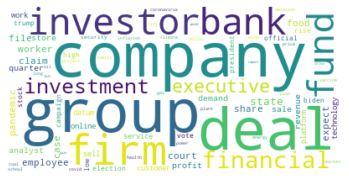

ASTRAZENECA


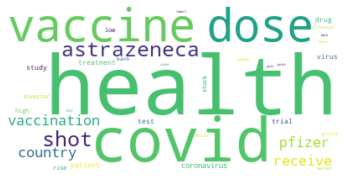

GILEAD SCIENCES


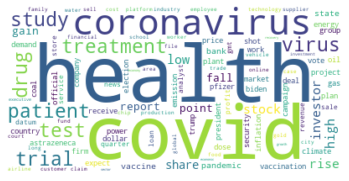

TEXAS INSTRUMENTS


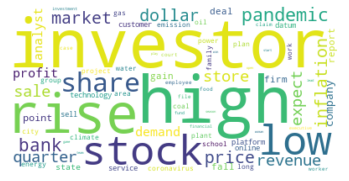

ROSS STORES


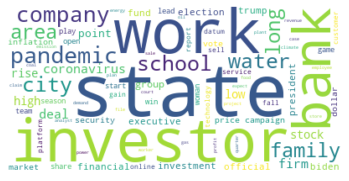

In [50]:
import random

comps = random.sample(list(merged['company']),5)
for c in comps:
    print(c)
    show_wordcloud(c)